# Perceptron Algorithm Example

Let's implement a simple perceptron (single-layer binary classifier) on a toy dataset to demonstrate basic machine learning concepts before moving to encrypted data.

# Scientific Demonstration: Privacy-Preserving Machine Learning with Homomorphic Encryption

This notebook demonstrates how to perform simple machine learning inference (a perceptron for the AND logic gate) on encrypted data using [TenSEAL](https://github.com/OpenMined/TenSEAL). You will learn:

- What homomorphic encryption is and why it enables privacy-preserving computation.
- The difference between the BFV and CKKS encryption schemes.
- How quantization and encryption parameters affect accuracy and usability.
- How to visualize and interpret the effects of encryption on ML predictions.

**Goal:**
- Show how a perceptron can be evaluated on encrypted data, and what practical caveats arise.
- Provide scientific insight into the trade-offs of encrypted ML workflows.

---

## What is Homomorphic Encryption?
Homomorphic encryption (HE) allows computations to be performed directly on encrypted data, producing encrypted results that can be decrypted to obtain the correct answer as if the computation was performed on plaintext. This is crucial for privacy-preserving machine learning, where sensitive data can be processed by untrusted servers without revealing the raw data.

**Key properties:**
- Data remains encrypted during computation.
- Only the data owner can decrypt the results.
- Enables secure outsourcing of computation (e.g., cloud ML inference).

---

In [1]:
import numpy as np

# Toy dataset: AND logic gate
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])
y = np.array([0, 0, 0, 1])  # AND output

# Perceptron implementation

In [2]:
class Perceptron:
    def __init__(self, n_inputs, lr=0.1, n_epochs=10):
        self.weights = np.zeros(n_inputs + 1)  # +1 for bias
        self.lr = lr
        self.n_epochs = n_epochs

    def predict(self, x):
        z = np.dot(x, self.weights[1:]) + self.weights[0]
        return 1 if z >= 0 else 0

    def fit(self, X, y):
        for epoch in range(self.n_epochs):
            for xi, target in zip(X, y):
                pred = self.predict(xi)
                update = self.lr * (target - pred)
                self.weights[1:] += update * xi
                self.weights[0] += update

# Train the perceptron

In [3]:

perceptron = Perceptron(n_inputs=2, lr=0.1, n_epochs=10)
perceptron.fit(X, y)
print("Trained weights:", perceptron.weights)

Trained weights: [-0.2  0.2  0.1]


In [4]:
# Test the perceptron
for xi, target in zip(X, y):
    pred = perceptron.predict(xi)
    print(f"Input: {xi}, Predicted: {pred}, Actual: {target}")

Input: [0 0], Predicted: 0, Actual: 0
Input: [0 1], Predicted: 0, Actual: 0
Input: [1 0], Predicted: 0, Actual: 0
Input: [1 1], Predicted: 1, Actual: 1


This simple perceptron learns the AND logic gate. You can try changing the dataset to OR or XOR and see how the perceptron performs.

**Next steps:**  
- Try encrypting the data and running the perceptron operations using TenSEAL vectors.
- Explore how homomorphic encryption affects the perceptron's ability to learn and predict.

# Encrypted Perceptron Inference with TenSEAL

Now let's use TenSEAL to encrypt the input data and perform perceptron inference (prediction) on encrypted data. We'll use the trained weights from the plaintext perceptron and show how to compute the perceptron output using encrypted vectors.

## Homomorphic Encryption Schemes: BFV vs. CKKS

**BFV (Brakerski/Fan-Vercauteren):**
- Supports exact integer arithmetic on encrypted data.
- Requires quantization (scaling and rounding) of real-valued data to integers.
- Good for applications where all values are integers, but quantization can introduce errors for ML models with real weights.

**CKKS (Cheon-Kim-Kim-Song):**
- Supports approximate real-number arithmetic on encrypted data.
- No need for quantization; can use real-valued weights and inputs directly.
- Well-suited for most machine learning and scientific computing tasks.

### Caveats and Practical Considerations
- **Quantization (BFV):** Scaling up real values to integers can cause rounding errors and loss of precision. Too small a scale leads to large errors; too large a scale can cause integer overflow.
- **Scale (CKKS):** Controls the precision of real-number arithmetic. Too small a scale leads to loss of precision; too large a scale can cause noise growth and decryption errors.
- **Parameter Selection:** Security and correctness depend on encryption parameters (polynomial modulus degree, coefficient modulus, etc.). Larger parameters increase security and precision, but also slow down computation and increase memory usage.

---

In [5]:
import tenseal as ts

# Create a TenSEAL context for BFV scheme (integer operations)
context = ts.context(
    ts.SCHEME_TYPE.BFV,
    poly_modulus_degree=4096,
    plain_modulus=1032193
    
)
context.generate_galois_keys()

In [6]:
# Encrypt the input vectors using BFV
encrypted_inputs = [ts.bfv_vector(context, xi) for xi in X]

In [7]:
# Use the trained weights (rounded to int for BFV)
scale = 10
w = np.round(perceptron.weights[1:] * scale).astype(int)
b = int(np.round(perceptron.weights[0] * scale))

print("Using weights:", w, "and bias:", b)

Using weights: [2 1] and bias: -2


In [8]:
# Try a higher scale to reduce quantization error

w = np.round(perceptron.weights[1:] * scale).astype(int)
b = int(np.round(perceptron.weights[0] * scale))

print("Using weights:", w, "and bias:", b, "(scale:", scale, ")")

encrypted_outputs = []
z_values = []
for i, enc_x in enumerate(encrypted_inputs):
    enc_wx = enc_x * w
    enc_sum = enc_wx.sum() + b
    z = enc_sum.decrypt()
    z_val = z[0] if isinstance(z, list) else z
    z_values.append(z_val)
    pred = 1 if z_val >= 0 else 0
    encrypted_outputs.append(pred)
    print(f"Input {i}: decrypted z = {z_val}")
print("Encrypted perceptron predictions:", encrypted_outputs)
print("Actual labels:", y.tolist())

Using weights: [2 1] and bias: -2 (scale: 10 )
Input 0: decrypted z = -2
Input 1: decrypted z = -1
Input 2: decrypted z = 0
Input 3: decrypted z = 1
Encrypted perceptron predictions: [0, 0, 1, 1]
Actual labels: [0, 0, 0, 1]


In [9]:
# Diagnostics: Compare plaintext and encrypted perceptron outputs
print("\n--- Diagnostics: Plaintext vs Encrypted ---")
print(f"Original perceptron weights: {perceptron.weights[1:]}, bias: {perceptron.weights[0]}")
print(f"Scaled weights: {w}, scaled bias: {b}")

for i, xi in enumerate(X):
    z_plain = np.dot(xi, perceptron.weights[1:]) + perceptron.weights[0]
    z_enc = z_values[i] / scale  # De-quantize
    pred_plain = 1 if z_plain >= 0 else 0
    pred_enc = encrypted_outputs[i]
    print(f"Input {i}: x={xi}, Plain z={z_plain:.4f}, Enc z={z_enc:.4f}, Plain pred={pred_plain}, Enc pred={pred_enc}, Label={y[i]}")

print("\nIf encrypted z values are close to plaintext z, but predictions differ, try increasing scale further or check for integer overflow.")


--- Diagnostics: Plaintext vs Encrypted ---
Original perceptron weights: [0.2 0.1], bias: -0.20000000000000004
Scaled weights: [2 1], scaled bias: -2
Input 0: x=[0 0], Plain z=-0.2000, Enc z=-0.2000, Plain pred=0, Enc pred=0, Label=0
Input 1: x=[0 1], Plain z=-0.1000, Enc z=-0.1000, Plain pred=0, Enc pred=0, Label=0
Input 2: x=[1 0], Plain z=-0.0000, Enc z=0.0000, Plain pred=0, Enc pred=1, Label=0
Input 3: x=[1 1], Plain z=0.1000, Enc z=0.1000, Plain pred=1, Enc pred=1, Label=1

If encrypted z values are close to plaintext z, but predictions differ, try increasing scale further or check for integer overflow.


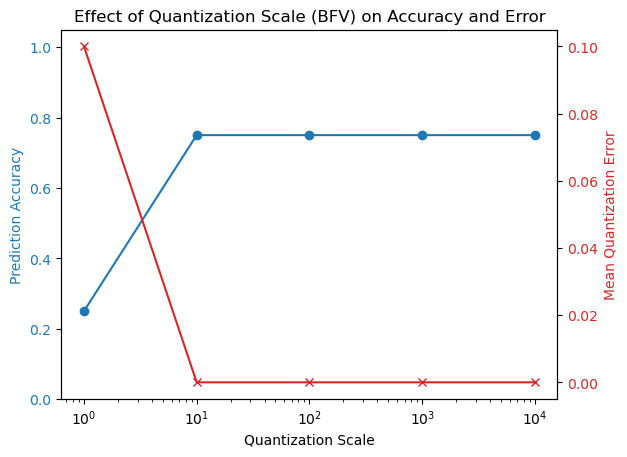

In [10]:
# Plot: Effect of Quantization Scale on BFV Prediction Accuracy
import matplotlib.pyplot as plt

scales = [1, 10, 100, 1000, 10000]
accuracies = []
errors = []

for scale in scales:
    w = np.round(perceptron.weights[1:] * scale).astype(int)
    b = int(np.round(perceptron.weights[0] * scale))
    preds = []
    z_errs = []
    for xi, target in zip(X, y):
        z_plain = np.dot(xi, perceptron.weights[1:]) + perceptron.weights[0]
        z_enc = (np.dot(xi, w) + b) / scale
        pred = 1 if z_enc >= 0 else 0
        preds.append(pred)
        z_errs.append(abs(z_plain - z_enc))
    acc = np.mean(np.array(preds) == y)
    accuracies.append(acc)
    errors.append(np.mean(z_errs))

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Quantization Scale')
ax1.set_ylabel('Prediction Accuracy', color=color)
ax1.plot(scales, accuracies, marker='o', color=color)
ax1.set_xscale('log')
ax1.set_ylim(0, 1.05)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mean Quantization Error', color=color)
ax2.plot(scales, errors, marker='x', color=color)
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Effect of Quantization Scale (BFV) on Accuracy and Error')
plt.show()

In [11]:
# Encrypted Perceptron Inference with CKKS (real-valued)
print("\n--- Encrypted Perceptron Inference with CKKS ---")
ckks_context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
ckks_context.generate_galois_keys()
ckks_context.global_scale = 2**40

# Encrypt the input vectors using CKKS
ckks_encrypted_inputs = [ts.ckks_vector(ckks_context, xi) for xi in X]

ckks_outputs = []
ckks_z_values = []
for i, enc_x in enumerate(ckks_encrypted_inputs):
    # Multiply encrypted input by real weights
    enc_wx = enc_x * perceptron.weights[1:]
    enc_sum = enc_wx.sum() + perceptron.weights[0]
    z = enc_sum.decrypt()
    z_val = z[0] if isinstance(z, list) else z
    ckks_z_values.append(z_val)
    pred = 1 if z_val >= 0 else 0
    ckks_outputs.append(pred)
    print(f"Input {i}: decrypted z = {z_val}")
print("CKKS encrypted perceptron predictions:", ckks_outputs)
print("Actual labels:", y.tolist())


--- Encrypted Perceptron Inference with CKKS ---
Input 0: decrypted z = -0.19999967681401362
Input 1: decrypted z = -0.09999965844606645
Input 2: decrypted z = 3.4251836879273245e-07
Input 3: decrypted z = 0.10000035715219477
CKKS encrypted perceptron predictions: [0, 0, 1, 1]
Actual labels: [0, 0, 0, 1]


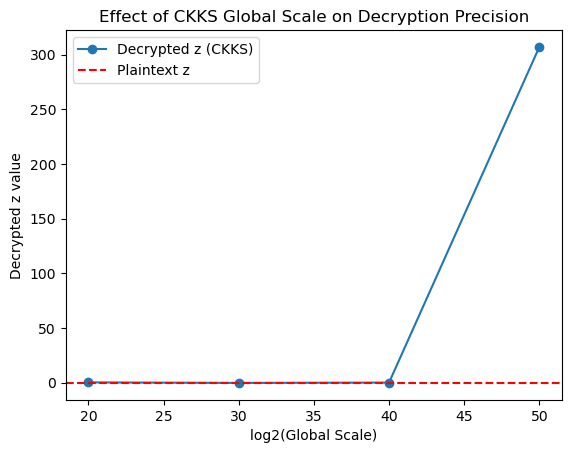

In [12]:
# Plot: Effect of CKKS Global Scale on Decryption Precision
ckks_scales = [2**20, 2**30, 2**40, 2**50]
ckks_zs = []
plain_z = np.dot(X[3], perceptron.weights[1:]) + perceptron.weights[0]  # Use [1,1] input
for scale in ckks_scales:
    ctx = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    ctx.global_scale = scale
    ctx.generate_galois_keys()
    enc_x = ts.ckks_vector(ctx, X[3])
    enc_wx = enc_x * perceptron.weights[1:]
    enc_sum = enc_wx.sum() + perceptron.weights[0]
    z = enc_sum.decrypt()
    z_val = z[0] if isinstance(z, list) else z
    ckks_zs.append(z_val)

plt.figure()
plt.plot([np.log2(s) for s in ckks_scales], ckks_zs, marker='o', label='Decrypted z (CKKS)')
plt.axhline(plain_z, color='r', linestyle='--', label='Plaintext z')
plt.xlabel('log2(Global Scale)')
plt.ylabel('Decrypted z value')
plt.title('Effect of CKKS Global Scale on Decryption Precision')
plt.legend()
plt.show()

**Note:**  
- In this example, only the input data is encrypted. The weights and bias are kept in plaintext for simplicity.
- The perceptron activation (step function) is applied after decryption, since non-linear functions are not directly supported in BFV.
- This demonstrates privacy-preserving inference: the server can compute predictions on encrypted data without seeing the raw inputs.

You can experiment with other logic gates or datasets, and try using the CKKS scheme for real-valued data!

---

## Scientific Takeaways and Further Reading

- **Homomorphic encryption** enables privacy-preserving computation, but comes with trade-offs in performance, accuracy, and parameter selection.
- **BFV** is suitable for integer-only workflows, but quantization can introduce significant errors for ML models with real-valued weights.
- **CKKS** allows real-number computation, making it more practical for most ML and scientific applications, but results are approximate.
- **Parameter tuning** (scale, modulus degree, etc.) is critical for balancing security, accuracy, and efficiency.
- **Visualization** helps understand the impact of encryption parameters on model performance and output fidelity.

### Further Reading
- [TenSEAL Documentation](https://github.com/OpenMined/TenSEAL)
- [Microsoft SEAL Manual](https://github.com/microsoft/SEAL)
- [Homomorphic Encryption Standardization](https://homomorphicencryption.org/)
- [OpenMined Blog: Privacy-Preserving ML](https://blog.openmined.org/)

**Try experimenting with:**
- Different logic gates or datasets
- Training on encrypted data (more advanced)
- Varying encryption parameters and observing effects
- Using TenSEAL in real-world privacy-preserving ML workflows

---